# RSTDP domain adaptation of pre-trained agents for modified CartPole environments

In [19]:
import os
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

from utils import evaluate_policy, rstdp_train_cartpole

import site
site.addsitedir('../src/')

from dsnn import RSTDPNet

%matplotlib inline

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 2
rstdp_episodes = 2

In [4]:
# Create environments
original_env = gym.make(env_name)

modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 1.5

In [5]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [8, 64, 64, 2]

In [6]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [7]:
evaluation_seeds = np.load('../seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('../seeds/rstdp_training_seeds.npy')

In [18]:
# Load pre-trained model weights
weights_0 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_2.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2]

In [9]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained models on original environment

In [10]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00


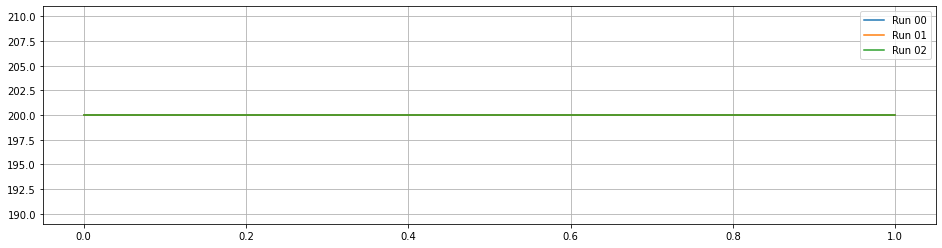

In [11]:
plt.figure(figsize=(16, 4))

for i, oer in enumerate(original_eval_rewards):
    plt.plot(oer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### Evaluate pre-trained models on modified environment

In [13]:
modified_env_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    modified_env_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  147.50


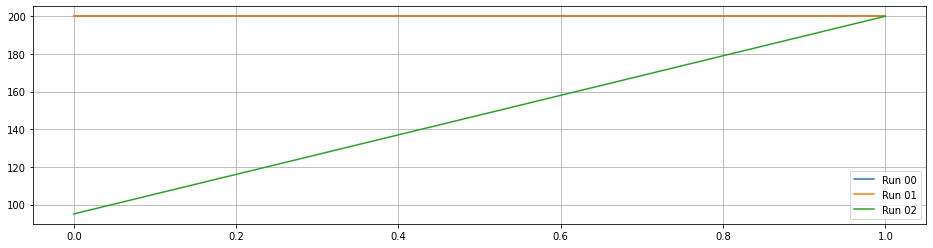

In [14]:
plt.figure(figsize=(16, 4))

for i, meer in enumerate(modified_env_eval_rewards):
    plt.plot(meer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### RSTDP Adaptation

In [15]:
rstdp_adaptation_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    w_plus = deepcopy(w[0][1])
    w_minus = deepcopy(w[0][1])
    w_plus[w_plus < 0] = 0
    w_minus[w_minus > 0] = 0
    A_plus = torch.mean(w_plus)
    A_minus = torch.abs(torch.mean(w_minus))
    
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  tau, tau_e, A_plus, A_minus, C, 
                                  device=device, dtype=dtype)
    
    adapted_weights, rewards = rstdp_train_cartpole(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    rstdp_adaptation_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

Episode:    1 -- Reward:  200.00 -- Best reward:  142.00 in episode    0
Best individual stored after episode 1 with reward 200.00

Episode:    0 -- Reward:  200.00 -- Best reward:    -inf in episode   -1
Best individual stored after episode 0 with reward 200.00

Episode:    1 -- Reward:  147.50 -- Best reward:  147.50 in episode    0
Best individual stored after episode 0 with reward 147.50



### Evaluate adapted models on modified environment

In [16]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  200.00
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  147.50


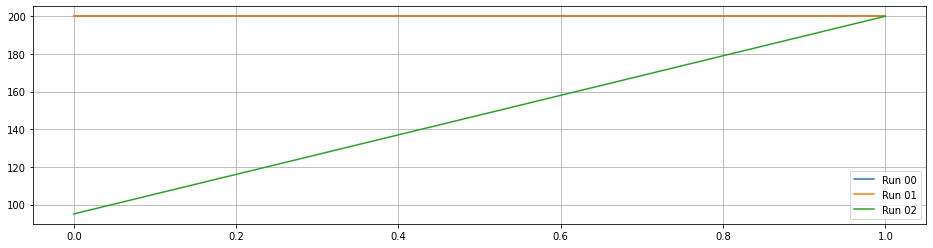

In [17]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()